# Notebook 1: Leitura e Exploração dos Dados

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
Neste notebook vamos:
1. Importar os dados da planilha Excel do distrito de distribuição de gás
2. Explorar a estrutura de cada aba (colunas, tipos, quantidade de dados)
3. Identificar dados brutos vs dados derivados (calculados)
4. Gerar estatísticas descritivas básicas
5. Verificar dados faltantes e inconsistências

### Contexto
A planilha contém dados operacionais de um **distrito de distribuição de gás natural** com:
- Medições de **entrada** (volume, PCS, energia) comparando Concessionária e Transportadora
- Dados horários de **7 clientes** (volume, pressão, temperatura)
- Análises de **balanço** e **incertezas** de medição
- Período: **abril a setembro de 2025** (183 dias)

## 1. Importação das Bibliotecas

In [1]:
import sys
from pathlib import Path

# Configurar caminhos do projeto
PROJECT_ROOT = Path('.').resolve().parent if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from config import DATA_DIR, GRAFICOS_DIR, EXCEL_DEFAULT

EXCEL_PATH = DATA_DIR / EXCEL_DEFAULT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações gerais
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:,.2f}'.format)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print('Bibliotecas carregadas com sucesso!')

Bibliotecas carregadas com sucesso!


## 2. Leitura do Arquivo Excel

A planilha possui **14 abas**. Vamos primeiro listar todas as abas disponíveis e depois carregar cada uma individualmente, pois cada aba tem uma estrutura diferente.

In [2]:
# Listar todas as abas
xl = pd.ExcelFile(EXCEL_PATH)
print(f'Total de abas: {len(xl.sheet_names)}\n')
for i, nome in enumerate(xl.sheet_names, 1):
    print(f'  {i:2d}. {nome}')

Total de abas: 14

   1. Vol Entrada Gas
   2. PCS Ent 
   3. Energia Ent
   4. Cliente #1
   5. Cliente #2
   6. Cliente #3
   7. Cliente #4
   8. Cliente #5
   9. Cliente #6
  10. Cliente #7
  11. Sumario das Medições
  12. Incertezas 
  13. Balanço
  14. Planilha1


## 3. Aba "Vol Entrada Gas" - Volumes Diários de Entrada

Esta aba compara os volumes diários medidos pela **Concessionária** e pela **Transportadora** no ponto de entrada do distrito. A concordância entre ambas as medições é essencial para a transferência de custódia.

In [3]:
# Leitura da aba de volumes de entrada
# Os dados começam na linha 2 (header na linha 1) e as colunas úteis são B a F
df_vol_entrada = pd.read_excel(
    EXCEL_PATH, 
    sheet_name='Vol Entrada Gas',
    header=1,           # Linha do cabeçalho
    usecols='B:F'       # Colunas B até F
)

print(f'Formato: {df_vol_entrada.shape}')
print(f'\nColunas: {list(df_vol_entrada.columns)}')
print(f'\nTipos de dados:')
print(df_vol_entrada.dtypes)
print(f'\nPrimeiras 5 linhas:')
df_vol_entrada.head()

Formato: (199, 5)

Colunas: ['Unnamed: 1', 'Concessionária Nm3/d', 'Transportadora Nm3/d', 'Dif Abs', 'Dif %']

Tipos de dados:
Unnamed: 1              object
Concessionária Nm3/d    object
Transportadora Nm3/d    object
Dif Abs                 object
Dif %                   object
dtype: object

Primeiras 5 linhas:


,Unnamed: 1,Concessionária Nm3/d,Transportadora Nm3/d,Dif Abs,Dif %
0,2025-04-01 00:00:00,"839,428.19",839428,0.19,0.00
1,2025-04-02 00:00:00,"838,410.88",838411,-0.12,-0.00
2,2025-04-03 00:00:00,"802,091.38",802091,0.38,0.00
3,2025-04-04 00:00:00,"987,160.12",987160,0.12,0.00
4,2025-04-05 00:00:00,"1,067,652.62",1067653,-0.38,-0.00


In [4]:
# Renomear colunas para facilitar o trabalho
# Vamos verificar os nomes originais e padronizar
print('Nomes originais das colunas:')
for i, col in enumerate(df_vol_entrada.columns):
    print(f'  [{i}] {repr(col)}')

Nomes originais das colunas:
  [0] 'Unnamed: 1'
  [1] 'Concessionária Nm3/d'
  [2] 'Transportadora Nm3/d'
  [3] 'Dif Abs'
  [4] 'Dif %'


In [5]:
# Limpar dados: remover linhas de resumo (AVERAGE, MIN, MAX) que ficam no final
# Manter apenas linhas com datas válidas
df_vol_entrada_raw = df_vol_entrada.copy()

# Identificar a coluna de data (primeira coluna)
col_data = df_vol_entrada.columns[0]
df_vol_entrada = df_vol_entrada.dropna(subset=[col_data])

# Converter para datetime se necessário
df_vol_entrada[col_data] = pd.to_datetime(df_vol_entrada[col_data], errors='coerce')
df_vol_entrada = df_vol_entrada.dropna(subset=[col_data])

print(f'Linhas de dados válidos: {len(df_vol_entrada)}')
print(f'Período: {df_vol_entrada[col_data].min()} a {df_vol_entrada[col_data].max()}')
print(f'\nÚltimas 5 linhas:')
df_vol_entrada.tail()

Linhas de dados válidos: 183


Período: 2025-04-01 00:00:00 a 2025-09-30 00:00:00

Últimas 5 linhas:


,Unnamed: 1,Concessionária Nm3/d,Transportadora Nm3/d,Dif Abs,Dif %
178,2025-09-26,"1,027,460.12",1027460,0.12,0.00
179,2025-09-27,"1,083,484.88",1083485,-0.12,-0.00
180,2025-09-28,"1,093,346.25",1093346,0.25,0.00
181,2025-09-29,"1,102,152.50",1102153,-0.50,-0.00
182,2025-09-30,"878,328.94",878329,-0.06,-0.00


In [6]:
# Estatísticas descritivas
print('=== Estatísticas - Volumes de Entrada (Nm³/d) ===')
df_vol_entrada.describe()

=== Estatísticas - Volumes de Entrada (Nm³/d) ===


,Unnamed: 1
count,183
mean,2025-07-01 00:00:00
min,2025-04-01 00:00:00
25%,2025-05-16 12:00:00
50%,2025-07-01 00:00:00
75%,2025-08-15 12:00:00
max,2025-09-30 00:00:00


## 4. Aba "PCS Ent" - Poder Calorífico Superior

O **PCS (Poder Calorífico Superior)** indica a quantidade de energia contida em cada metro cúbico de gás (kcal/m³). É fundamental para a comercialização de energia.

In [7]:
# Leitura da aba de PCS
# NOTA: O nome da aba tem um espaço no final: 'PCS Ent '
df_pcs = pd.read_excel(
    EXCEL_PATH, 
    sheet_name='PCS Ent ',  # Espaço no final é intencional
    header=1,
    usecols='B:F'
)

# Limpar: manter apenas linhas com datas válidas
col_data_pcs = df_pcs.columns[0]
df_pcs[col_data_pcs] = pd.to_datetime(df_pcs[col_data_pcs], errors='coerce')
df_pcs = df_pcs.dropna(subset=[col_data_pcs])

print(f'Formato: {df_pcs.shape}')
print(f'Período: {df_pcs[col_data_pcs].min()} a {df_pcs[col_data_pcs].max()}')
print(f'\nColunas: {list(df_pcs.columns)}')
print(f'\nEstatísticas:')
df_pcs.describe()

Formato: (183, 5)


Período: 2025-04-01 00:00:00 a 2025-09-30 00:00:00

Colunas: ['Unnamed: 1', 'Concessionária kcal/m3', 'Trnsportadora kcal/m3', 'Dif Abs', 'Dif %']

Estatísticas:


,Unnamed: 1
count,183
mean,2025-07-01 00:00:00
min,2025-04-01 00:00:00
25%,2025-05-16 12:00:00
50%,2025-07-01 00:00:00
75%,2025-08-15 12:00:00
max,2025-09-30 00:00:00


## 5. Aba "Energia Ent" - Energia Diária

A energia é calculada como: **Energia (kcal) = Volume (Nm³) × PCS (kcal/Nm³)**

In [8]:
# Leitura da aba de energia
# NOTA: Coluna B está vazia nesta aba, dados começam na coluna C
df_energia = pd.read_excel(
    EXCEL_PATH, 
    sheet_name='Energia Ent',
    header=1,
    usecols='C:J'  # Dados de C a J (B está vazia)
)

# Limpar dados
col_data_en = df_energia.columns[0]
df_energia[col_data_en] = pd.to_datetime(df_energia[col_data_en], errors='coerce')
df_energia = df_energia.dropna(subset=[col_data_en])

print(f'Formato: {df_energia.shape}')
print(f'\nColunas:')
for i, col in enumerate(df_energia.columns):
    print(f'  [{i}] {col}')
print(f'\nPrimeiras linhas:')
df_energia.head()

Formato: (184, 8)

Colunas:
  [0] Vol Concessionária m3
  [1] PC Concessionária kcal/m3
  [2] Energia Concessionária kcal
  [3] Vol Transportadora m3
  [4] PC Transportadora Kcal/m3
  [5] Energia Transportadora kcal
  [6] Dif Abs
  [7] Dif %

Primeiras linhas:


,Vol Concessionária m3,PC Concessionária kcal/m3,Energia Concessionária kcal,Vol Transportadora m3,PC Transportadora Kcal/m3,Energia Transportadora kcal,Dif Abs,Dif %
0,1970-01-01 00:00:00.000839428,"9,774.69","8,205,153,164.13","839,428.00","9,775.00","8,205,408,700.00","-255,535.87",-0.00
1,1970-01-01 00:00:00.000838410,"9,629.97","8,073,874,424.52","838,411.00","9,630.00","8,073,897,930.00","-23,505.48",-0.00
2,1970-01-01 00:00:00.000802091,"9,668.40","7,754,938,645.87","802,091.00","9,668.00","7,754,615,788.00","322,857.87",0.00
3,1970-01-01 00:00:00.000987160,"9,614.43","9,490,979,255.27","987,160.00","9,614.00","9,490,556,240.00","423,015.27",0.00
4,1970-01-01 00:00:00.001067652,"9,588.80","10,237,509,198.84","1,067,653.00","9,589.00","10,237,724,617.00","-215,418.16",-0.00


In [9]:
# Estatísticas de energia
print('=== Estatísticas - Energia de Entrada (kcal) ===')
df_energia.describe()

=== Estatísticas - Energia de Entrada (kcal) ===


,Vol Concessionária m3,PC Concessionária kcal/m3,Energia Concessionária kcal,Vol Transportadora m3,PC Transportadora Kcal/m3,Energia Transportadora kcal,Dif Abs,Dif %
count,184,183.00,183.00,183.00,183.00,184.00,184.00,184.00
mean,1970-01-01 00:00:00.000999561,"9,538.92","9,536,231,886.60","999,562.11","9,538.91","9,536,227,816.57","-51,817,844.78",-51.84
min,1970-01-01 00:00:00.000505964,"9,167.85","4,779,246,288.25","505,965.00","9,168.00","4,779,345,390.00","-9,535,228,254.55","-9,539.41"
25%,1970-01-01 00:00:00.000906232,"9,468.24","8,527,234,642.37","906,216.00","9,468.00","8,541,479,180.50","-227,906.37",-0.00
50%,1970-01-01 00:00:00.001047207,"9,541.73","9,978,459,720.90","1,048,720.00","9,542.00","9,976,962,817.00","13,133.43",0.00
75%,1970-01-01 00:00:00.001115319,"9,611.41","10,671,165,280.04","1,115,515.50","9,611.50","10,662,160,405.75","241,175.78",0.00
max,1970-01-01 00:00:00.001240864,"9,785.96","11,730,525,650.47","1,240,865.00","9,786.00","11,731,137,710.00","535,009.25",0.00
std,NaN,104.34,"1,617,957,824.42","168,609.19",104.34,"1,613,536,664.62","702,946,714.23",703.25


## 6. Abas dos Clientes - Dados Horários

Cada cliente possui dados de medição **horária** (4.344 registros) com:
- **Volume** (Nm³/h) - vazão horária
- **Pressão** (bara) - pressão absoluta
- **Temperatura** (°C) - temperatura do gás

Vamos carregar todos os 7 clientes em um dicionário para fácil acesso.

In [10]:
# Mapeamento: nome da aba -> nome real do cliente
CLIENTES_NOMES = {
    'Cliente #1': 'Empresa A',
    'Cliente #2': 'Empresa B',
    'Cliente #3': 'Empresa C',
    'Cliente #4': 'Empresa D',
    'Cliente #5': 'Empresa E',
    'Cliente #6': 'Empresa F',
    'Cliente #7': 'Empresa G'
}

# Volume conhecido da Planilha1 para clientes sem dados horários
VOLUMES_REFERENCIA = {
    'Empresa D': 88184  # Nm³ total no período (da aba Planilha1)
}

# Carregar dados de cada cliente
clientes = {}

for aba, nome in CLIENTES_NOMES.items():
    try:
        df = pd.read_excel(
            EXCEL_PATH, 
            sheet_name=aba,
            header=2,           # Cabeçalho na linha 3
            usecols='B:E'       # Data, Volume, Pressão, Temperatura
        )
        
        # Limpar: manter apenas linhas com timestamps válidos
        col_data_cli = df.columns[0]
        df[col_data_cli] = pd.to_datetime(df[col_data_cli], errors='coerce')
        df = df.dropna(subset=[col_data_cli])
        
        # Padronizar nomes das colunas
        df.columns = ['Data', 'Volume_Nm3h', 'Pressao_bara', 'Temperatura_C']
        
        # Converter colunas numéricas
        for col in ['Volume_Nm3h', 'Pressao_bara', 'Temperatura_C']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        if len(df) == 0 or df['Volume_Nm3h'].notna().sum() == 0:
            print(f'! {aba} ({nome}): SEM DADOS HORÁRIOS', end='')
            if nome in VOLUMES_REFERENCIA:
                print(f' (volume de referência: {VOLUMES_REFERENCIA[nome]:,.0f} Nm³)')
            else:
                print()
            clientes[aba] = {
                'nome': nome,
                'dados': df,
                'sem_dados': True,
                'vol_referencia': VOLUMES_REFERENCIA.get(nome, 0)
            }
        else:
            clientes[aba] = {
                'nome': nome,
                'dados': df,
                'sem_dados': False
            }
            print(f'  {aba} ({nome}): {len(df)} registros')
    except Exception as e:
        print(f'X {aba} ({nome}): ERRO - {e}')

print(f'\nTotal de clientes carregados: {len(clientes)}')

  Cliente #1 (Empresa A): 4344 registros


  Cliente #2 (Empresa B): 4344 registros


  Cliente #3 (Empresa C): 4367 registros


  Cliente #4 (Empresa D): 4344 registros


  Cliente #5 (Empresa E): 4344 registros


  Cliente #6 (Empresa F): 4344 registros


  Cliente #7 (Empresa G): 4344 registros

Total de clientes carregados: 7


In [11]:
# Resumo de cada cliente
print('=== Resumo por Cliente ===')
print(f'{"Cliente":<25} {"Registros":>10} {"Vol Min":>12} {"Vol Méd":>12} {"Vol Max":>12} {"Vol Total (Mm³)":>16}')
print('-' * 90)

for aba, info in clientes.items():
    df = info['dados']
    nome = info['nome']
    vol = df['Volume_Nm3h']
    vol_total = vol.sum() / 1e6  # Converter para milhões de Nm³
    print(f'{nome:<25} {len(df):>10,} {vol.min():>12,.0f} {vol.mean():>12,.0f} {vol.max():>12,.0f} {vol_total:>16,.2f}')

=== Resumo por Cliente ===
Cliente                    Registros      Vol Min      Vol Méd      Vol Max  Vol Total (Mm³)
------------------------------------------------------------------------------------------
Empresa A                    4,344        1,359       23,965       31,245           104.10
Empresa B            4,344          178       10,052       17,113            43.66
Empresa C              4,367            0        1,567        4,959             6.84
Empresa D                     4,344            0           47          187             0.09
Empresa E           4,344          300        2,345        4,244            10.18
Empresa F                    4,344            0        1,372        3,509             5.96
Empresa G                   4,344          418        2,321        7,085            10.08


## 7. Verificação de Dados Faltantes

In [12]:
# Verificar dados faltantes nos dados de entrada
print('=== Dados Faltantes (NaN) ===')
print(f'\nVolumes de Entrada:')
print(df_vol_entrada.isnull().sum())

print(f'\nPCS:')
print(df_pcs.isnull().sum())

print(f'\nEnergia:')
print(df_energia.isnull().sum())

=== Dados Faltantes (NaN) ===

Volumes de Entrada:
Unnamed: 1              0
Concessionária Nm3/d    0
Transportadora Nm3/d    0
Dif Abs                 0
Dif %                   0
dtype: int64

PCS:
Unnamed: 1                0
Concessionária kcal/m3    0
Trnsportadora kcal/m3     0
Dif Abs                   0
Dif %                     0
dtype: int64

Energia:
Vol Concessionária m3          0
PC Concessionária kcal/m3      1
Energia Concessionária kcal    1
Vol Transportadora m3          1
PC Transportadora Kcal/m3      1
Energia Transportadora kcal    0
Dif Abs                        0
Dif %                          0
dtype: int64


In [13]:
# Verificar dados faltantes nos clientes
print('=== Dados Faltantes por Cliente ===')
for aba, info in clientes.items():
    df = info['dados']
    faltantes = df.isnull().sum()
    total = faltantes.sum()
    if total > 0:
        print(f'\n{info["nome"]} ({aba}):')
        print(faltantes[faltantes > 0])
    else:
        print(f'{info["nome"]} ({aba}): Sem dados faltantes')

=== Dados Faltantes por Cliente ===
Empresa A (Cliente #1): Sem dados faltantes
Empresa B (Cliente #2): Sem dados faltantes
Empresa C (Cliente #3): Sem dados faltantes

Empresa D (Cliente #4):
Volume_Nm3h      2483
Pressao_bara     2483
Temperatura_C    2483
dtype: int64
Empresa E (Cliente #5): Sem dados faltantes
Empresa F (Cliente #6): Sem dados faltantes
Empresa G (Cliente #7): Sem dados faltantes


## 8. Abas de Análise

As abas de análise contêm cálculos derivados: sumário das medições, incertezas, balanço de massa. Diferente das abas de dados brutos, estas têm **layout com margens** (linhas e colunas vazias no início) e **estrutura hierárquica** (células mescladas). É necessário especificar `skiprows` e `usecols` para extrair apenas a área de dados útil.

| Aba | Área de dados | Descrição |
|-----|---------------|-----------|
| Sumário das Medições | Linhas 6-15, Colunas D:K | Condições operacionais por ponto |
| Incertezas | Linhas 5+, Colunas E:I | Incertezas de medição por tramo/cliente |
| Balanço (Tab.1) | Linhas 5-19, Colunas E:I | Incertezas (cópia) |
| Balanço (Tab.2) | Linhas 23-24, Colunas L:P | Banda de variação (entrada vs saída) |
| Planilha1 | Linhas 3+, Colunas C:H | Consolidação final com bandas |

In [ ]:
# =====================================================================
# Aba: "Sumario das Medições" — Condições Operacionais
# Área de dados: linhas 6-15, colunas D:K (8 colunas)
# Estrutura hierárquica: col D = categoria (Ponto de Entrada/Saída),
#                        col E = medidor/cliente
# =====================================================================
print('=' * 70)
print('Aba: "Sumario das Medições" — Condições Operacionais')
print('  Parâmetros: skiprows=6, nrows=10, usecols="D:K", header=None')
print('=' * 70)

df_sumario = pd.read_excel(
    EXCEL_PATH, sheet_name='Sumario das Medições',
    header=None, skiprows=6, nrows=10, usecols='D:K'
)
df_sumario.columns = [
    'Categoria', 'Ponto/Medidor', 'Vol Mín (Nm³/h)', 'Vol Normal (Nm³/h)',
    'Vol Máx (Nm³/h)', 'Pressão Máx (bar.a)', 'Pressão Normal (bar.a)',
    'Temp Máx (°C)'
]
df_sumario['Categoria'] = df_sumario['Categoria'].ffill()
df_sumario = df_sumario.dropna(subset=['Ponto/Medidor'])
for col in df_sumario.columns[2:]:
    df_sumario[col] = pd.to_numeric(df_sumario[col], errors='coerce')

print(f'Formato: {df_sumario.shape}\n')
print(df_sumario.to_string(index=False))

# =====================================================================
# Aba: "Incertezas " — Incertezas por Ponto de Medição
# Área de dados: linhas 5+, colunas E:I (5 colunas)
# Mostra todos os 5 tramos de entrada + 7 clientes + totais
# =====================================================================
print('\n' + '=' * 70)
print('Aba: "Incertezas " — Incertezas por Ponto de Medição')
print('  Parâmetros: skiprows=5, usecols="E:I", header=None')
print('=' * 70)

df_incertezas = pd.read_excel(
    EXCEL_PATH, sheet_name='Incertezas ',
    header=None, skiprows=5, usecols='E:I'
)
df_incertezas.columns = [
    'Categoria', 'Ponto/Medidor', 'Inc. Vazão Mín (%)',
    'Inc. Vazão Normal (%)', 'Inc. Vazão Máx (%)'
]
df_incertezas['Categoria'] = df_incertezas['Categoria'].ffill()
df_incertezas = df_incertezas.dropna(subset=['Ponto/Medidor'])
for col in df_incertezas.columns[2:]:
    df_incertezas[col] = pd.to_numeric(df_incertezas[col], errors='coerce')

print(f'Formato: {df_incertezas.shape}\n')
print(df_incertezas.to_string(index=False))

# =====================================================================
# Aba: "Balanço" — Tabela 1: Incertezas (mesma estrutura da aba Incertezas)
# Área de dados: linhas 5-19, colunas E:I
# =====================================================================
print('\n' + '=' * 70)
print('Aba: "Balanço" — Tabela 1: Incertezas por Ponto')
print('  Parâmetros: skiprows=5, nrows=15, usecols="E:I", header=None')
print('=' * 70)

df_bal_inc = pd.read_excel(
    EXCEL_PATH, sheet_name='Balanço',
    header=None, skiprows=5, nrows=15, usecols='E:I'
)
df_bal_inc.columns = [
    'Categoria', 'Ponto/Medidor', 'Inc. Vazão Mín (%)',
    'Inc. Vazão Normal (%)', 'Inc. Vazão Máx (%)'
]
df_bal_inc['Categoria'] = df_bal_inc['Categoria'].ffill()
df_bal_inc = df_bal_inc.dropna(subset=['Ponto/Medidor'])
for col in df_bal_inc.columns[2:]:
    df_bal_inc[col] = pd.to_numeric(df_bal_inc[col], errors='coerce')

print(f'Formato: {df_bal_inc.shape}\n')
print(df_bal_inc.to_string(index=False))

# =====================================================================
# Aba: "Balanço" — Tabela 2: Banda de Variação
# Área de dados: linhas 23-24, colunas L:P (segunda tabela na mesma aba)
# Contém: volumes transferidos com bandas de incerteza para entrada e saída
# =====================================================================
print('\n' + '=' * 70)
print('Aba: "Balanço" — Tabela 2: Banda de Variação')
print('  Parâmetros: skiprows=23, nrows=3, usecols="L:P", header=None')
print('=' * 70)

df_bal_banda = pd.read_excel(
    EXCEL_PATH, sheet_name='Balanço',
    header=None, skiprows=23, nrows=3, usecols='L:P'
)
df_bal_banda.columns = [
    'Ponto', 'Vol Transferido (Nm³)', 'Inc. Normal (%)',
    'Valor Mín (Nm³)', 'Valor Máx (Nm³)'
]
df_bal_banda = df_bal_banda.dropna(subset=['Ponto'])
for col in df_bal_banda.columns[1:]:
    df_bal_banda[col] = pd.to_numeric(df_bal_banda[col], errors='coerce')

print(f'Formato: {df_bal_banda.shape}\n')
print(df_bal_banda.to_string(index=False))

# =====================================================================
# Aba: "Planilha1" — Tabela Consolidada com Bandas de Incerteza
# Área de dados: linhas 3+, colunas C:H (6 colunas)
# Consolida volumes, incertezas e bandas min/max para todos os pontos
# =====================================================================
print('\n' + '=' * 70)
print('Aba: "Planilha1" — Tabela Consolidada com Bandas de Incerteza')
print('  Parâmetros: skiprows=3, usecols="C:H", header=None')
print('=' * 70)

df_planilha1 = pd.read_excel(
    EXCEL_PATH, sheet_name='Planilha1',
    header=None, skiprows=3, usecols='C:H'
)
df_planilha1.columns = [
    'Categoria', 'Ponto/Medidor', 'Vol Transferido (Nm³)',
    'Inc. Normal (%)', 'Valor Mín (Nm³)', 'Valor Máx (Nm³)'
]
df_planilha1['Categoria'] = df_planilha1['Categoria'].ffill()
df_planilha1 = df_planilha1.dropna(subset=['Ponto/Medidor'])
for col in df_planilha1.columns[2:]:
    df_planilha1[col] = pd.to_numeric(df_planilha1[col], errors='coerce')

print(f'Formato: {df_planilha1.shape}\n')
print(df_planilha1.to_string(index=False))

## 9. Visualização Rápida dos Dados

Uma visão geral rápida para confirmar que os dados foram carregados corretamente.

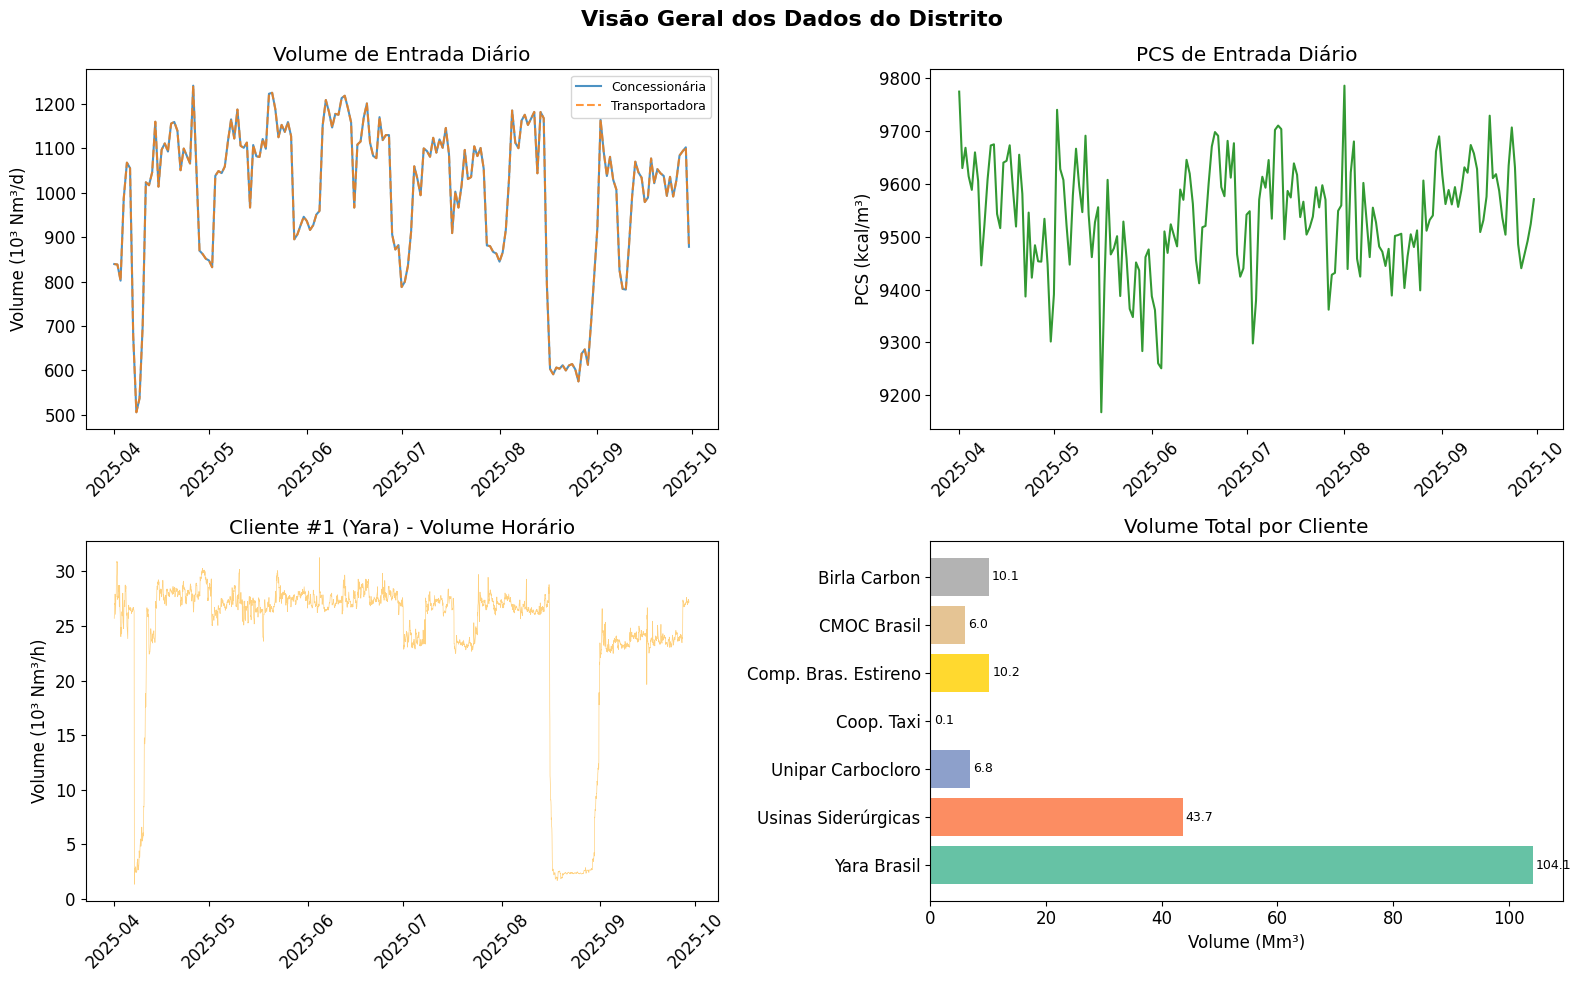

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Visão Geral dos Dados do Distrito', fontsize=16, fontweight='bold')

# 1. Volumes de entrada diários
ax = axes[0, 0]
col_conc = df_vol_entrada.columns[1]  # Concessionária
col_transp = df_vol_entrada.columns[2]  # Transportadora
ax.plot(df_vol_entrada[df_vol_entrada.columns[0]], 
        df_vol_entrada[col_conc] / 1000, 
        label='Concessionária', alpha=0.8)
ax.plot(df_vol_entrada[df_vol_entrada.columns[0]], 
        df_vol_entrada[col_transp] / 1000, 
        label='Transportadora', alpha=0.8, linestyle='--')
ax.set_title('Volume de Entrada Diário')
ax.set_ylabel('Volume (10³ Nm³/d)')
ax.legend(fontsize=9)
ax.tick_params(axis='x', rotation=45)

# 2. PCS diário
ax = axes[0, 1]
col_pcs_conc = df_pcs.columns[1]
ax.plot(df_pcs[df_pcs.columns[0]], df_pcs[col_pcs_conc], color='green', alpha=0.8)
ax.set_title('PCS de Entrada Diário')
ax.set_ylabel('PCS (kcal/m³)')
ax.tick_params(axis='x', rotation=45)

# 3. Volume do maior cliente (Cliente #1 - Empresa A)
ax = axes[1, 0]
df_yara = clientes['Cliente #1']['dados']
ax.plot(df_yara['Data'], df_yara['Volume_Nm3h'] / 1000, 
        color='orange', alpha=0.5, linewidth=0.5)
ax.set_title('Cliente #1 (Empresa A) - Volume Horário')
ax.set_ylabel('Volume (10³ Nm³/h)')
ax.tick_params(axis='x', rotation=45)

# 4. Volume total por cliente
ax = axes[1, 1]
nomes = [info['nome'] for info in clientes.values()]
volumes = [info['dados']['Volume_Nm3h'].sum() / 1e6 for info in clientes.values()]
cores = plt.cm.Set2(np.linspace(0, 1, len(nomes)))
bars = ax.barh(nomes, volumes, color=cores)
ax.set_title('Volume Total por Cliente')
ax.set_xlabel('Volume (Mm³)')
for bar, vol in zip(bars, volumes):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{vol:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Resumo da Exploração

### Dados disponíveis:

| Aba | Tipo | Registros | Granularidade | Colunas-chave |
|-----|------|-----------|---------------|---------------|
| Vol Entrada Gas | Dados diários | 183 | Diária | Volume Concessionária/Transportadora (Nm³/d) |
| PCS Ent | Dados diários | 183 | Diária | PCS Concessionária/Transportadora (kcal/m³) |
| Energia Ent | Dados diários | 183 | Diária | Energia = Vol × PCS (kcal) |
| Cliente #1-7 | Dados horários | ~4.344 cada | Horária | Volume (Nm³/h), Pressão (bara), Temp (°C) |
| Sumário | Análise | - | - | Condições operacionais por ponto |
| Incertezas | Análise | - | - | Incertezas por ponto de medição |
| Balanço | Análise | - | - | Balanço entrada/saída com bandas |
| Planilha1 | Consolidação | - | - | Tabela final consolidada |

### Próximos passos:
- **Notebook 2:** Análise detalhada dos volumes de entrada
- **Notebook 3:** Análise do PCS
- **Notebook 4:** Cálculo de energia
- **Notebook 5:** Perfis dos clientes
- **Notebook 6:** Sumário e incertezas
- **Notebook 7:** Balanço de massa